In [33]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import onnx2tf
import tensorflow as tf
from PIL import Image

# Helper Functions


In [6]:
def c_style_hexdump(input, ouput, name):
    with open(input, "rb") as f:
        file = f.read()

    file = bytearray(file)
    _bytes = [f"0x{x:02x}" for x in file]
    file = ",".join(_bytes)

    with open(ouput, "w") as f:
        f.write("#pragma once\n")
        f.write("#include <stdalign.h>\n")
        f.write(f"alignas(16) const unsigned char {name}[] = {{{file}}};")

    return len(_bytes)


def build_header(output, names_with_sizes):
    with open(output, "w") as f:
        f.write('#pragma once\n#ifdef __cplusplus\nextern "C"\n{\n#endif\n')
        f.write("#include <stdalign.h>\n\n")
        for name, size in names_with_sizes:
            f.write(f"alignas(16) extern const unsigned char {name}[{size}];\n")
        f.write("\n#ifdef __cplusplus\n}\n#endif\n")

## PCA functions


In [40]:
def compute_covariance_matrix(A):
    # INPUT:
    # A    [NxM] centered numpy data matrix (N samples, M features)
    #
    # OUTPUT:
    # C    [MxM] numpy covariance matrix (M features, M features)
    #
    # Do not apply centering here. We assume that A is centered before this function is called.

    C = np.dot(A.T, A) / (A.shape[0] - 1)

    return C


def center_data(A):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    #
    # OUTPUT:
    # X    [NxM] numpy centered data matrix (N samples, M features)
    return A - np.mean(A, axis=0)


def compute_eigenvalue_eigenvectors(A):
    # INPUT:
    # A    [DxD] numpy matrix
    #
    # OUTPUT:
    # eigval    [D] numpy vector of eigenvalues
    # eigvec    [DxD] numpy array of eigenvectors

    eigval, eigvec = np.linalg.eig(A)

    # Numerical roundoff can lead to (tiny) imaginary parts. We correct that here.
    eigval = eigval.real
    eigvec = eigvec.real

    return eigval, eigvec


def sort_eigenvalue_eigenvectors(eigval, eigvec):
    # INPUT:
    # eigval    [D] numpy vector of eigenvalues
    # eigvec    [DxD] numpy array of eigenvectors
    #
    # OUTPUT:
    # sorted_eigval    [D] numpy vector of eigenvalues
    # sorted_eigvec    [DxD] numpy array of eigenvectors

    sorted_eigval = np.sort(eigval)[::-1]
    sorted_eigvec = eigvec[:, eigval.argsort()[::-1]]

    return sorted_eigval, sorted_eigvec


def pca(A, m):
    """
    Takes as input a data matrix A (with N samples and M features) and a
    number of features m (with m <= M) and returns the eigenvectors and the PCA data matrix.

    Returns:
        pca_eigvec: [Mxm] numpy matrix containing the eigenvectors (M dimensions, m eigenvectors)
        P: [Nxm] numpy PCA data matrix (N samples, m features)
    """

    A = center_data(A)

    pca_eigvec = sort_eigenvalue_eigenvectors(
        *compute_eigenvalue_eigenvectors(compute_covariance_matrix(A))
    )[1][:, :m]

    P = np.dot(pca_eigvec, A)

    return pca_eigvec, P


def encode_decode_pca_with_pov(A, p):
    """
    Accepts a data matrix A (with N samples and M features) and a floating point
    number p (with 0 < p < 1) denoting the POV to be preserved and returns a tuple
    consisting of the reconstructed data matrix Ahat and the number of dimensions selected m.

    Returns:
        Ahat: [NxM] numpy PCA reconstructed data matrix (N samples, M features)
        m:   integer reporting the number of dimensions selected
    """

    eigval, eigvec = compute_eigenvalue_eigenvectors(
        compute_covariance_matrix(center_data(A))
    )

    cum_var_ratio = np.cumsum(eigval) / np.sum(eigval)
    m = np.argmax(cum_var_ratio >= p) + 1  # add 1 for the case of index 0

    pca_eigvec = sort_eigenvalue_eigenvectors(eigval, eigvec)[1][:, :m]

    # ENCODE
    P = np.dot(pca_eigvec.T, A.T).T

    # DECODE
    Ahat = np.dot(P, pca_eigvec.T) + np.mean(A, axis=0)

    return Ahat, m

# Convert the model to `.tflite`


In [7]:
ONNX_PATH = "fastest_det/example/onnx-runtime/FastestDet.onnx"

In [8]:
saved_model_fastest_det = tempfile.mkdtemp()

onnx2tf.convert(
    ONNX_PATH,
    output_integer_quantized_tflite=True,
    output_h5=True,
    output_folder_path=saved_model_fastest_det,
)


Model optimizing started ============================================================
Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃             ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Add         │ 1              │ 1                │
│ AveragePool │ 1              │ 1                │
│ Concat      │ 19             │ 19               │
│ Constant    │ 150            │ 150              │
│ Conv        │ 70             │ 70               │
│ Gather      │ 26             │ 26               │
│ MaxPool     │ 1              │ 1                │
│ Relu        │ 48             │ 48               │
│ Reshape     │ 26             │ 26               │
│ Resize      │ 1              │ 1                │
│ Sigmoid     │ 1              │ 1                │
│ Softmax     │ 1              │ 1                │
│ Transpose   │ 15             │ 15               │
│ Model Size  │ 972.6KiB       │ 9

fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


INT8 Quantization tflite output complete!


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


Full INT8 Quantization tflite output complete!
INT8 Quantization with int16 activations tflite output complete!
Full INT8 Quantization with int16 activations tflite output complete!


In [9]:
def representative_dataset():
    for _ in range(100):
        data = np.random.rand(1, 352, 352, 3)
        yield [data.astype(np.float32)]

## Convert using full-int quantization, the board has little support for floating point operations


In [10]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_fastest_det)

converter.optimizations = [tf.lite.Optimize.DEFAULT]  # type: ignore

converter.representative_dataset = representative_dataset  # type: ignore

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # type: ignore
converter.inference_output_type = tf.uint8  # type: ignore

## Save in temp directory and analyze it


In [11]:
file = converter.convert()

_, fastest_det_quant_file = tempfile.mkstemp(".tflite")

with open(fastest_det_quant_file, "wb") as f:
    f.write(file)

print(os.stat(fastest_det_quant_file))

os.stat_result(st_mode=33152, st_ino=75717, st_dev=2080, st_nlink=1, st_uid=1000, st_gid=1000, st_size=421264, st_atime=1718006924, st_mtime=1718006924, st_ctime=1718006924)


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [12]:
tf.lite.experimental.Analyzer.analyze(fastest_det_quant_file)

=== /tmp/tmpp_3awvm3.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the QUANTIZE op takes
tensor #0 as input and produces tensor #154 as output.

Subgraph#0 main(T#0) -> [T#364]
  Op#0 QUANTIZE(T#0) -> [T#154]
  Op#1 PAD(T#154, T#1[0, 0, 1, 1, 1, ...]) -> [T#155]
  Op#2 CONV_2D(T#155, T#153, T#152[96096, 32069, 39896, 44835, 4403, ...]) -> [T#156]
  Op#3 PAD(T#156, T#1[0, 0, 1, 1, 1, ...]) -> [T#157]
  Op#4 MAX_POOL_2D(T#157) -> [T#158]
  Op#5 PAD(T#158, T#1[0, 0, 1, 1, 1, ...]) -> [T#159]
  Op#6 DEPTHWISE_CONV_2D(T#159, T#151, T#150[3594, -14518, -4413, -6670, 2754, ...]) -> [T#160]
  Op#7 CONV_2D(T#158, T#149, T#148[-20454, -9270, 8147, -5194, 18453, ...]) -> [T#161]
  Op#8 PAD(T#161, T#1[0, 0, 1, 1, 1, ...]) -> [T#162]
  Op#9 DEPTHWISE_CONV_2D(T#162, T#147, T#146[230, 10273, -6011, -4975, 387, ...]) -> [T#163]
  Op#10 CONV_2D(T#160, T#145, T#144[3780, -597, 1932, 3688, 912, ...]) -> 

### Build the interpreter


In [13]:
interpreter = tf.lite.Interpreter(fastest_det_quant_file)
interpreter.allocate_tensors()
sig = interpreter.get_signature_list()

print(sig)

{'serving_default': {'inputs': ['input.1'], 'outputs': ['758']}}


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


#### Output tensor analysis


In [14]:
out = interpreter.get_output_details()

print(out)

[{'name': 'PartitionedCall:0', 'index': 364, 'shape': array([ 1, 22, 22, 85], dtype=int32), 'shape_signature': array([ 1, 22, 22, 85], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.028094099834561348, 94), 'quantization_parameters': {'scales': array([0.0280941], dtype=float32), 'zero_points': array([94], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [15]:
interpreter.get_tensor(out[0]["index"])

array([[[[167, 120,  79, ...,  38,  61, 129],
         [166, 204,  61, ..., 189, 150,  48],
         [204,  60, 166, ..., 152, 203, 144],
         ...,
         [ 61,  44, 110, ...,  95, 220,  59],
         [157,   2,  21, ...,  65,  61,  98],
         [ 66, 220,  60, ..., 188, 131, 255]],

        [[ 58,  60,  59, ...,  95,  79,   0],
         [189, 173, 151, ...,  90, 169,  59],
         [ 84,  10, 180, ..., 174, 188,  42],
         ...,
         [ 61, 192, 188, ..., 190,  87,   1],
         [222,  61,  21, ..., 178,  92,  62],
         [ 61,  42, 250, ..., 108,   8,  61]],

        [[148, 117,  88, ...,  46,  61, 168],
         [ 91,  44, 190, ...,  61, 124, 163],
         [ 79, 190, 145, ...,  47, 126, 184],
         ...,
         [ 60, 161, 186, ...,  77, 214, 186],
         [208, 222, 155, ..., 147, 189,   5],
         [251,  38, 190, ...,  62, 158, 216]],

        ...,

        [[230,  61, 118, ...,  20,  67, 106],
         [189,  49, 182, ..., 152,  50,  61],
         [235, 142

#### Input tensor analysis


In [16]:
input_details = interpreter.get_input_details()
input_scale, input_zero_point = input_details[0]["quantization"]

print(input_scale, input_zero_point)

0.003921568859368563 0


## Generate headers


### Generate header for the model dump


In [17]:
# https://github.com/tensorflow/tensorflow/issues/43749

MODEL = "models/fastest_det_rom.c"

model_size = c_style_hexdump(fastest_det_quant_file, MODEL, "model_data")

### Generate header for the input data


In [25]:
INPUT = "models/fastest_det_input.c"
TEST_IMAGE = "fastest_det/data/3.jpg"

In [59]:
img = Image.open(TEST_IMAGE)
img = img.convert("RGB")

#### Plot original image and compressed image


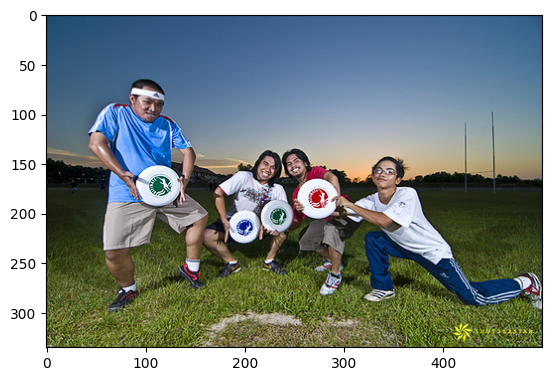

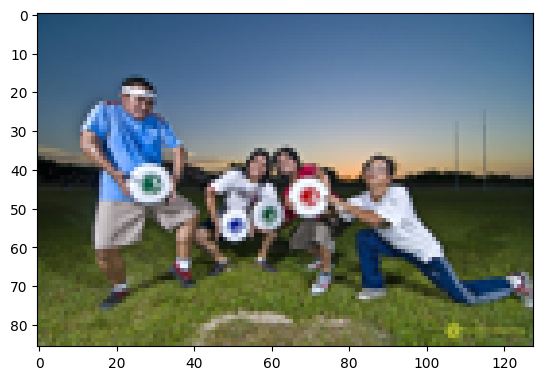

In [60]:
img_array = np.array(img)
img_array = img_array.astype(np.uint8)

plt.imshow(img_array)
plt.show()

img.thumbnail((128, 128))
img_array_compressed = np.array(img)
img_array_compressed = img_array_compressed.astype(np.uint8)

plt.imshow(img)
plt.show()

#### Generate header


In [61]:
# image = tf.cast(img_array.flatten() / input_scale + input_zero_point, tf.uint8)

_, imagebin = tempfile.mkstemp(".bin")

with open(imagebin, "wb") as f:
    f.write(bytearray(img_array_compressed))  # type: ignore

input_size = c_style_hexdump(imagebin, INPUT, "input_data")

### Generate header for model and input data


In [62]:
HEADER = "models/fastest_det.h"

build_header(HEADER, [("input_data", input_size), ("model_data", model_size)])